# Алгоритм разбиения бизнесс процесса на подпроцессы по журналу событий основанный на кластеризации трасс
В данном блокноте представлен алгоритм разбиения бизнесс процесса на подпроцессы по журналу событий и его применение 
на журнале событий:
1. [BPI Challenge 2015 Municipality 4](https://data.4tu.nl/articles/_/12697898/1)

## Оглавление:
1. Подгатовка данных
2. Применение алгоритма



#### 1. Подгатовка данных

Для начала подключим необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns

Подгрузим данные. Формат журнала событий ___.xes___ и далее работать с таким форматом будет не очень удобно, поэтому преобразуем его с помощью функций библиотеки pm4py к формату ___.csv___ и сохраним в текущей директории

In [2]:
event_log_xes = pm4py.read_xes("../Data/BPIC15_4/BPIC15_4.xes")
event_log_csv = pm4py.convert_to_dataframe(event_log_xes)
event_log_csv.to_csv("../Data/BPIC15_4/BPIC15_4.csv", index=False)

/home/anna/.local/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
/home/anna/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 1053/1053 [00:02<00:00, 380.64it/s]


Теперь уже откроем журнал событий с помощью pandas

In [3]:
df = pd.read_csv("../Data/BPIC15_4/BPIC15_4.csv")
df.head(5)

/tmp/ipykernel_1597367/3558787022.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/BPIC15_4/BPIC15_4.csv")


,question,dateFinished,dueDate,action_code,activityNameEN,planned,time:timestamp,monitoringResource,org:resource,activityNameNL,...,case:case_type,case:startDate,case:requestComplete,case:IDofConceptCase,case:termName,case:caseProcedure,case:landRegisterID,case:Includes_subCases,dateStop,case:endDatePlanned
0,EMPTY,2014-08-06 00:00:00,2014-08-11 08:28:55+00:00,01_HOOFD_010,register submission date request,2014-08-07 08:28:55+00:00,2014-08-05 00:00:00+00:00,560752,560752,registratie datum binnenkomst aanvraag,...,557669,2014-08-05 00:00:00+00:00,True,10002463.0,NaN,NaN,NaN,NaN,NaN,NaN
1,True,2014-08-06 00:00:00,NaN,04_BPT_005,regular procedure without MER,2014-08-07 08:35:32+00:00,2014-08-06 00:00:00+00:00,1550894,560752,reguliere procedure zonder MER,...,557669,2014-08-05 00:00:00+00:00,True,10002463.0,NaN,NaN,NaN,NaN,NaN,NaN
2,True,2014-08-06 00:00:00,NaN,01_HOOFD_065_0,create procedure confirmation,2014-08-07 08:35:37+00:00,2014-08-06 00:00:00+00:00,1550894,560752,procedurebevestiging aanmaken,...,557669,2014-08-05 00:00:00+00:00,True,10002463.0,NaN,NaN,NaN,NaN,NaN,NaN
3,False,2014-08-06 00:00:00,NaN,01_HOOFD_090,publish,2014-08-07 08:37:32+00:00,2014-08-06 00:00:00+00:00,1550894,560752,publiceren,...,557669,2014-08-05 00:00:00+00:00,True,10002463.0,NaN,NaN,NaN,NaN,NaN,NaN
4,False,2014-08-06 00:00:00,NaN,01_HOOFD_110_0,create subcases completeness,2014-08-07 08:37:33+00:00,2014-08-06 00:00:00+00:00,1550894,560752,deelzaken volledigheid aanmaken,...,557669,2014-08-05 00:00:00+00:00,True,10002463.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(47293, 29)

In [5]:
df["concept:name"].unique()

array(['01_HOOFD_010', '04_BPT_005', '01_HOOFD_065_0', '01_HOOFD_090',
       '01_HOOFD_110_0', '01_HOOFD_180', '01_HOOFD_011', '01_HOOFD_020',
       '02_DRZ_010', '01_HOOFD_065_1', '01_HOOFD_015', '01_HOOFD_061',
       '01_HOOFD_065_2', '01_HOOFD_200', '01_HOOFD_250_0', '01_HOOFD_330',
       '09_AH_I_010', '01_HOOFD_380', '01_HOOFD_430', '11_AH_II_010',
       '13_CRD_010', '01_HOOFD_480', '01_HOOFD_490_2', '01_HOOFD_491',
       '08_AWB45_005', '01_HOOFD_494a', '01_HOOFD_490_1a',
       '01_HOOFD_490_1', '01_HOOFD_375', '01_HOOFD_195', '01_HOOFD_490_4',
       '01_HOOFD_500', '01_HOOFD_510_0', '01_HOOFD_490_5', '01_HOOFD_495',
       '01_HOOFD_490_5a', '01_HOOFD_510_1', '01_HOOFD_510_2',
       '01_HOOFD_510_3', '01_HOOFD_510_2a', '01_HOOFD_510_4',
       '01_HOOFD_515', '01_BB_540', '01_BB_775', '01_HOOFD_811',
       '01_BB_770', '01_HOOFD_012', '04_BPT_009', '04_BPT_020',
       '04_BPT_030', '04_BPT_029', '04_BPT_021', '01_HOOFD_030_1',
       '01_HOOFD_030_2', '08_AWB45_010',

In [8]:
code_case, unique_case = pd.factorize(df["case:concept:name"])
code_activity, unique_activity = pd.factorize(df["concept:name"])

In [9]:
print("Count of cases:", len(unique_case))
print("Count of activities:", len(unique_activity))


Count of cases: 1053
Count of activities: 356


In [10]:
df["code_case"] = code_case
df["code_activity"] = code_activity
grouped_df = df.groupby(df["code_case"])["code_activity"].agg(list).reset_index()
grouped_df["len"] = grouped_df["code_activity"].apply(lambda x : len(x))
grouped_df

,code_case,code_activity,len
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",46
1,1,"[0, 6, 7, 8, 1, 2, 3, 4, 5, 9, 10, 11, 12]",13
2,2,"[6, 7, 8, 1, 2, 3, 4, 5, 10, 0, 9, 11, 12]",13
3,3,"[0, 46, 7, 8, 1, 47, 48, 49, 2, 50, 10, 51, 9,...",116
4,4,"[0, 6, 7, 8, 1, 2, 3, 4, 5, 10, 9, 11, 12, 54,...",53
...,...,...,...
1048,1048,"[0, 8, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 24,...",53
1049,1049,"[0, 6, 7, 8, 1, 2, 3, 4, 5, 10, 11, 9, 12, 54,...",45
1050,1050,"[0, 6, 7, 8, 1, 47, 48, 139, 140, 138, 2, 3, 1...",70
1051,1051,"[0, 6, 7, 8, 1, 2, 3, 4, 5, 10, 11, 9, 12, 13,...",42


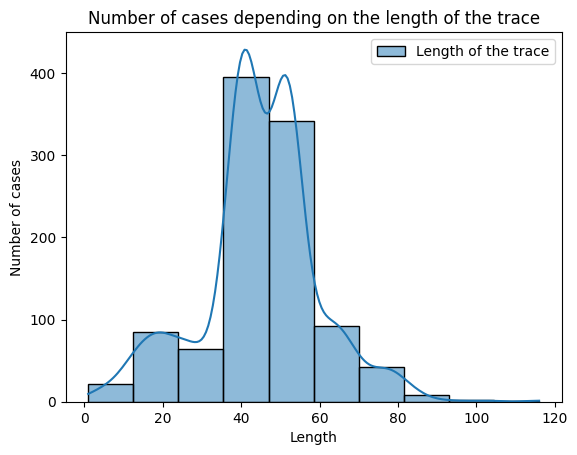

In [14]:
grouped_df_graph = grouped_df.drop(["code_case", "code_activity"], axis=1)
grouped_df_graph = grouped_df_graph.rename(columns={'len': 'Length of the trace'})
plot = sns.histplot(grouped_df_graph, bins=10, kde=True, color="skyblue")
plt.title("Number of cases depending on the length of the trace")
plt.xlabel("Length")
plt.ylabel("Number of cases")
plt.show()

In [15]:
mean_length = grouped_df_graph["Length of the trace"].mean()
mode_length = grouped_df_graph["Length of the trace"].mode()[0]
print("Средняя длинна слова:", mean_length)
print("Самая часто встречающаяся длинна слова:", mode_length)

Средняя длинна слова: 44.91263057929724
Самая часто встречающаяся длинна слова: 42


#### 1.2. Применение алгоритма

In [1]:
import LogSplitter
import Metrics

In [17]:
for_activity_df = df.groupby(df["code_case"])["concept:name"].agg(list).reset_index()
corpus = for_activity_df['concept:name'].to_list()

In [18]:
model = LogSplitter.LogSplitter(2)
model.fit(corpus)

In [19]:
max_dif, min_dif, average = 0, 10000000, 0
for i in range(10, 100, 10):
    temp_dif = 0
    for j in range(5):

        model.transform(for_activity_df, name_id='code_case', name_traces='concept:name', trace_parts=i/100)
        temp_dif += abs( model.class_to_is[0] - model.class_to_is[1])
    
    temp_dif /= 5

    print(i, model.len_part, temp_dif)
    max_dif = max(max_dif, temp_dif)
    min_dif = min(min_dif, temp_dif)
    average += temp_dif

print("min_dif:", min_dif)
print("max_dif:", max_dif)
print("average_dif:", average / 9)

10 4 289.0
20 8 254.2
30 13 251.0
40 17 564.6
50 22 426.2
60 26 602.2
70 30 706.6
80 35 713.8
90 39 477.0
min_dif: 251.0
max_dif: 713.8
average_dif: 476.0666666666667


In [20]:
for i in range(2, 5):
    model = LogSplitter.LogSplitter(i)
    model.fit(corpus)

    model.transform(for_activity_df, name_id='code_case', name_traces='concept:name', trace_parts=20/100)
    model.save_as_csv(df, "../Test/BPIC15_4/" + str(i) + "/1/")

    model.transform(for_activity_df, name_id='code_case', name_traces='concept:name', trace_parts=30/100)
    model.save_as_csv(df, "../Test/BPIC15_4/" + str(i) + "/2/")


In [4]:
metric = Metrics.Metric()
result = pd.DataFrame(columns=['Metric', '1', '2', '3', '4'])
e_cardoso_average = list()
e_cardoso_w_average = list()
pt_cd_average = list()
pt_cd_w_average = list()

e_cardoso_average.append("Average E-Cardoso")
e_cardoso_w_average.append("Weighted average E-Cardoso")
pt_cd_average.append("Average PT/CD")
pt_cd_w_average.append("Weighted average PT/CD")

t_df = [pd.read_csv("../Data/BPIC15_4/BPIC15_4.csv") for _ in range(1)]
t_df[0]["time:timestamp"] = pd.to_datetime(t_df[0]["time:timestamp"], format='ISO8601')
t_df[0]["case:concept:name"] = t_df[0]["case:concept:name"].astype(str)
metric.make_petri_net(t_df)
ans, e_average, e_w_average = metric.e_cardoso(t_df)
ans, pt_average, pt_w_average = metric.pt_cd(t_df)

e_cardoso_average.append(e_average.copy())
e_cardoso_w_average.append(e_w_average.copy())
pt_cd_average.append(pt_average.copy())
pt_cd_w_average.append(pt_w_average.copy())


for i in range(2, 5):
    t_df = [pd.read_csv("../Test/BPIC15_4/" + str(i) + "/1/" + str(j) + ".csv") for j in range(i)]
    for temp in t_df:
        temp["time:timestamp"] = pd.to_datetime(temp["time:timestamp"], format='ISO8601')
        temp["case:concept:name"] = temp["case:concept:name"].astype(str)
    metric.make_petri_net(t_df)
    ans, e_average, e_w_average = metric.e_cardoso(t_df)
    ans, pt_average, pt_w_average = metric.pt_cd(t_df)

    e_cardoso_average.append(e_average.copy())
    e_cardoso_w_average.append(e_w_average.copy())
    pt_cd_average.append(pt_average.copy())
    pt_cd_w_average.append(pt_w_average.copy())



/tmp/ipykernel_1602731/203080886.py:13: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  t_df = [pd.read_csv("../Data/BPIC15_4/BPIC15_4.csv") for _ in range(1)]
/tmp/ipykernel_1602731/203080886.py:27: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  t_df = [pd.read_csv("../Test/BPIC15_4/" + str(i) + "/1/" + str(j) + ".csv") for j in range(i)]


In [5]:
result.loc[len(result)] = e_cardoso_average
result.loc[len(result)] = e_cardoso_w_average
result.loc[len(result)] = pt_cd_average
result.loc[len(result)] = pt_cd_w_average

In [6]:
result

,Metric,1,2,3,4
0,Average E-Cardoso,514.000000,460.000000,232.666667,293.000000
1,Weighted average E-Cardoso,514.000000,460.097826,259.333948,308.648847
2,Average PT/CD,2.936113,2.829765,3.075108,2.791001
3,Weighted average PT/CD,2.936113,2.829571,3.036519,2.790698


In [ ]:
metric = Metrics.Metric()
result = pd.DataFrame(columns=['Metric', '1', '2', '3', '4'])


e_cardoso_average.append(e_cardoso_average[1])
e_cardoso_w_average.append(e_cardoso_w_average[1])
pt_cd_average.append(pt_cd_average[1])
pt_cd_w_average.append(pt_cd_w_average[1])


for i in range(2, 5):
    t_df = [pd.read_csv("../Test/BPIC15_4/" + str(i) + "/2/" + str(j) + ".csv") for j in range(i)]
    for temp in t_df:
        temp["time:timestamp"] = pd.to_datetime(temp["time:timestamp"], format='ISO8601')
        temp["case:concept:name"] = temp["case:concept:name"].astype(str)
    metric.make_petri_net(t_df)
    ans, e_average, e_w_average = metric.e_cardoso(t_df)
    ans, pt_average, pt_w_average = metric.pt_cd(t_df)

    e_cardoso_average.append(e_average.copy())
    e_cardoso_w_average.append(e_w_average.copy())
    pt_cd_average.append(pt_average.copy())
    pt_cd_w_average.append(pt_w_average.copy())


In [12]:
result.loc[len(result)] = e_cardoso_average[5:]
result.loc[len(result)] = e_cardoso_w_average[5:]
result.loc[len(result)] = pt_cd_average[5:]
result.loc[len(result)] = pt_cd_w_average[5:]

In [13]:
result

,Metric,1,2,3,4
0,Average E-Cardoso,514.000000,384.500000,307.666667,264.000000
1,Weighted average E-Cardoso,514.000000,420.668301,329.378116,280.946512
2,Average PT/CD,2.936113,2.878321,2.921372,2.825938
3,Weighted average PT/CD,2.936113,2.850549,2.919438,2.843743
